In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from f1tenth_benchmarks.utils.MapData import MapData

from f1tenth_benchmarks.data_tools.plotting_utils import *
import numpy as np

if os.getcwd().split('/')[-1] == 'benchmark_results':
    os.chdir('..')
    os.chdir('..')
    print(f'Changed directory to root of repo: {os.getcwd()}')

save_path = 'Data/ExtraUnusedPlots/'
if not os.path.exists(save_path):
    os.makedirs(save_path)

Changed directory to root of repo: /home/benjy/Documents/RacingRepos/f1tenth_sim


## Frequency


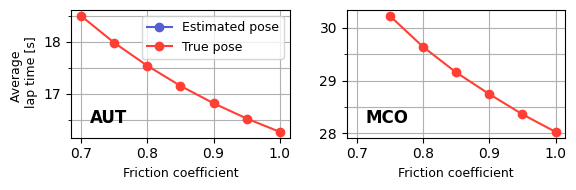

In [6]:
#TODO: add two graphs for two different maps

summary_df = pd.read_csv("Logs/Summary.csv")

planner = "FullStackPP"
friction_vals = np.linspace(0.55, 1, 10)
simulator_timestep_list = [2, 5, 10, 12, 14]

map_list = ["aut", "esp", "gbr", "mco"]

summary_df = summary_df[summary_df.Vehicle.isin(["FullStackPP300", "GlobalPlanPP"])]
test_ids = summary_df["TestID"].str.split("_", expand=True)
summary_df["mu"] = test_ids[0].str[2:].astype(float) / 100
timestep_series = test_ids[1].str[5:]
timestep_series.dropna(inplace=True)
summary_df["simulator_timestep"] = timestep_series.astype(int)
summary_df["frequency"] = 100 / summary_df["simulator_timestep"] 
summary_df["CompletionRate"] *= 100
summary_df["AvgProgress"] *= 100

selected_timesteps = [2]
summary_df = summary_df[summary_df["simulator_timestep"].isin(selected_timesteps)]

friction_vals = [0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1]
summary_df = summary_df[summary_df["mu"].isin(friction_vals)]

map_name = "aut"
size = 150

fig, axs = plt.subplots(1, 2, figsize=(6, 2.), sharex=True)
# fig = plt.figure(figsize=(5, 2.))

full_stack = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "FullStackPP")].sort_values("mu")
planning = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "GlobalPlanPP")].sort_values("mu")

axs[0].plot(full_stack["mu"], full_stack["AvgTime"], 'o-', label="Estimated pose", markersize=6, color=periwinkle)
axs[0].plot(planning["mu"], planning["AvgTime"], 'o-', label="True pose", markersize=6, color=red_orange)

map_name = "mco"
full_stack = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "FullStackPP")].sort_values("mu")
planning = summary_df[(summary_df["MapName"] == map_name) & (summary_df["Vehicle"] == "GlobalPlanPP")].sort_values("mu")

axs[1].plot(full_stack["mu"], full_stack["AvgTime"], 'o-', label="Estimated pose", markersize=6, color=periwinkle)
axs[1].plot(planning["mu"], planning["AvgTime"], 'o-', label="True pose", markersize=6, color=red_orange)

axs[0].yaxis.set_minor_locator(plt.MaxNLocator(5))
axs[1].yaxis.set_minor_locator(plt.MaxNLocator(5))
axs[0].set_xlabel("Friction coefficient", size=9)
axs[1].set_xlabel("Friction coefficient", size=9)
axs[0].set_ylabel("Average \n lap time [s]", size=9)
axs[0].legend(fontsize=9)
axs[1].grid(True, which='both')
axs[0].grid(True, which='both')

# axs[0].text(0.72, 16.5, "AUT", fontsize=12, fontdict={'weight': 'bold'})
# axs[1].text(0.72, 0.1, "MCO", fontsize=12, fontdict={'weight': 'bold'})
fig.text(0.18, 0.36, "AUT", fontsize=12, fontdict={'weight': 'bold'}, )
fig.text(0.64, 0.36, "MCO", fontsize=12, fontdict={'weight': 'bold'})
# axs[1].text(0.72, 28.2, "MCO", fontsize=12, fontdict={'weight': 'bold'})

plt.tight_layout()

plt.savefig(save_path + "FrictionLapTimes.svg", bbox_inches='tight')
plt.savefig(save_path + "FrictionLapTimes.pdf", bbox_inches='tight')


/tmp/ipykernel_505203/4015898697.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


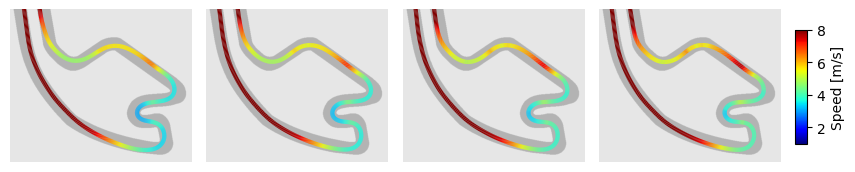

In [17]:
plot_map = "mco"
lap_n = 0
planner = "GlobalPlanPP"
mus = [0.7, 0.8, 0.9, 1.0]
test_ids = [f"mu{int(mu*100)}_steps2" for mu in mus]
lap_dfs = []
for i, test_id in enumerate(test_ids):
    data = np.load(f"Logs/{planner}/RawData_{test_id}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df["test_id"] = test_id
    lap_dfs.append(df)

lap_df = pd.concat(lap_dfs)
lap_df.dropna(inplace=True)



map_data = MapData(plot_map)
fig, axs = plt.subplots(1, len(mus), figsize=(8, 2.5), sharex=True, sharey=True)
for i in range(len(test_ids)):
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = lap_df[lap_df['test_id'] == test_ids[i]]
    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(1, 8)
    lc = LineCollection(segments, cmap='jet', norm=norm)
    lc.set_array(df.speed.values)
    lc.set_linewidth(3)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs[i].set_aspect('equal')
    plt.xlim(600, 1110)
    plt.ylim(70, 500)

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])
plt.tight_layout()


In [1]:
planner = "FullStackPP"
mu_vals = [0.7, 1.0]
test_ids = [f"mu{int(mu*100)}_steps2" for mu in mu_vals]
plot_map = "gbr"
lap_n = 0

lap_dfs = []
for i, test_id in enumerate(test_ids):
    data = np.load(f"Logs/{planner}/RawData_{test_id}/SimLog_{plot_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
    df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
    df["test_id"] = test_id
    lap_dfs.append(df)

lap_df = pd.concat(lap_dfs)
lap_df.dropna(inplace=True)


map_data = MapData(plot_map)
fig, axs = plt.subplots(1, len(test_ids), figsize=(8, 2.5), sharex=True, sharey=True)
for i in range(len(test_ids)):
    print(f"i: {i} - timestep: {test_ids[i]}")
    plt.sca(axs[i])
    map_data.plot_map_img()

    df = lap_df[lap_df['test_id'] == test_ids[i]]

    xs, ys = map_data.xy2rc(df.x, df.y)
    pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
    segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
    norm = plt.Normalize(1, 8)
    lc = LineCollection(segments, cmap='coolwarm', norm=norm)
    lc.set_array(df.speed.values)
    lc.set_linewidth(6)
    line = plt.gca().add_collection(lc)
    
    plt.axis('off')
    axs[i].set_aspect('equal')
    plt.xlim(840, 1160)
    plt.ylim(720, 860)

    axs[i].text(870, 722, f"$\mu$ = {mu_vals[0]}", fontsize=14, fontdict={'weight': 'bold'})

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height*1.1])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])
plt.tight_layout()

plt.savefig(f"{save_path}trajectory_mu_comparison_{map_name}.pdf", bbox_inches='tight')

NameError: name 'np' is not defined

## DRL

In [2]:

rewards = ["Progress", "CTH", "TAL"]
colors = [periwinkle, minty_green, red_orange]


/tmp/ipykernel_505203/1040126607.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


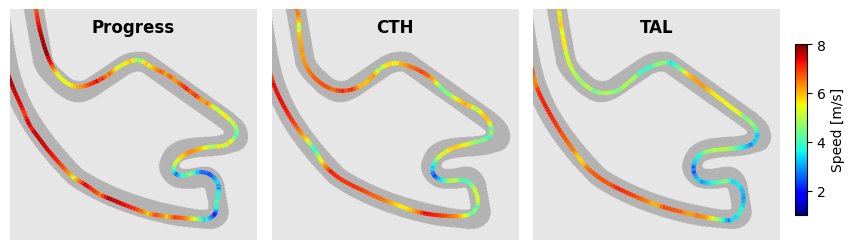

In [3]:
planner_name = "EndToEnd"
seed = 13
train_map = "mco"
test_map = "mco"
test_ids = [f"TD3_{reward}_{seed}_{train_map}" for reward in rewards]
frequency = 25
lap_n = 0

map_data = MapData(test_map)
fig, axs = plt.subplots(1, len(test_ids), figsize=(8, 10), sharex=True, sharey=True)

for i, test_id in enumerate(test_ids):
        data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{test_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
        df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])

        plt.sca(axs[i])
        map_data.plot_map_img()

        xs, ys = map_data.xy2rc(df.x, df.y)
        pts = np.array([xs, ys]).T.reshape(-1, 1, 2)
        segments = np.concatenate([pts[:-1], pts[1:]], axis=1)
        norm = plt.Normalize(1, 8)
        lc = LineCollection(segments, cmap='jet', norm=norm)
        lc.set_array(df.speed.values)
        lc.set_linewidth(3)
        line = plt.gca().add_collection(lc)


        plt.axis('off')
        axs[i].set_aspect('equal')
        plt.xlim(650, 1110)
        plt.ylim(70, 500)
        plt.text(0.5, 0.92, f"{rewards[i]}", horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes, fontsize=12, fontweight="bold")

ax = plt.gca()
cax = fig.add_axes([ax.get_position().x1+0.1, ax.get_position().y0, 0.015, ax.get_position().height])
plt.colorbar(line, cax=cax, label="Speed [m/s]", ticks=[2, 4, 6, 8])
plt.tight_layout()

plt.savefig(f"{save_path}drl_trajectories_{test_map}.svg", bbox_inches='tight')
plt.savefig(f"{save_path}drl_trajectories_{test_map}.pdf", bbox_inches='tight')


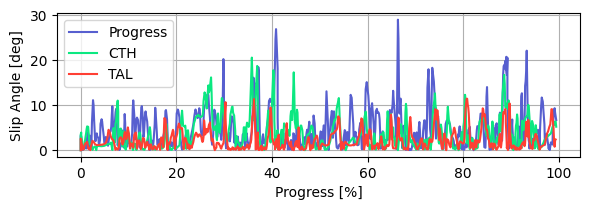

In [4]:
planner_name = "EndToEnd"
seed = 13
train_map = "mco"
test_map = "mco"
test_ids = [f"TD3_{reward}_{seed}_{train_map}" for reward in rewards]
frequency = 25
lap_n = 0

map_data = MapData(test_map)
fig, axs = plt.subplots(1, 1, figsize=(6, 2.2), sharex=True, sharey=True)

for i, test_id in enumerate(test_ids):
        data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{test_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
        df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
        df.slip = df.slip.abs() * 180 / np.pi

        plt.plot(df.progress*100, df.slip, label=rewards[i], color=colors[i])

plt.legend()
plt.grid(True)
plt.xlabel("Progress [%]")
plt.ylabel("Slip Angle [deg]")

plt.tight_layout()

plt.savefig(f"{save_path}drl_slip_progress_{test_map}.svg", bbox_inches='tight')
plt.savefig(f"{save_path}drl_slip_progress_{test_map}.pdf", bbox_inches='tight')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


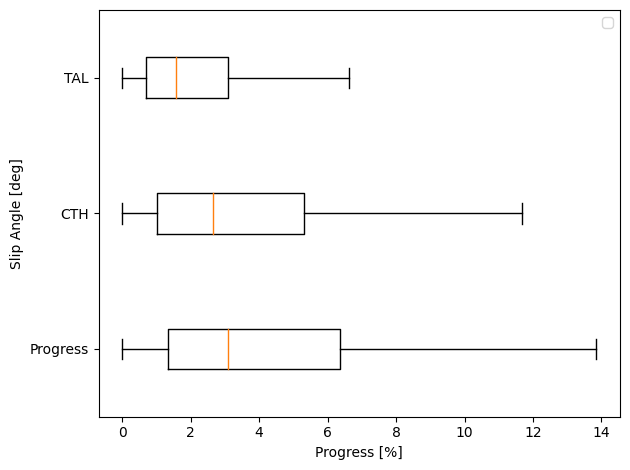

In [5]:
planner_name = "EndToEnd"
seed = 13
train_map = "mco"
test_map = "mco"
test_ids = [f"TD3_{reward}_{seed}_{train_map}" for reward in rewards]
frequency = 25
lap_n = 0

map_data = MapData(test_map)
fig, axs = plt.subplots(1, 1)

slips_angles = []
for i, test_id in enumerate(test_ids):
        data = np.load(f"Logs/{planner_name}/RawData_{test_ids[i]}/SimLog_{test_map}_{lap_n}.npy")[1:, :] #remove first repeated entry
        df = pd.DataFrame(data, columns=["x", "y", "steer", "speed", "yaw", "yaw_rate", "slip", "steer_a", "speed_a", "progress"])
        df.slip = df.slip.abs() * 180 / np.pi

        slips_angles.append(df.slip)

plt.boxplot(slips_angles, labels=rewards, showfliers=False, vert=False)

plt.legend()
plt.xlabel("Progress [%]")
plt.ylabel("Slip Angle [deg]")

plt.tight_layout()

plt.savefig(f"{save_path}drl_slip_progress_{test_map}.svg", bbox_inches='tight')
plt.savefig(f"{save_path}drl_slip_progress_{test_map}.pdf", bbox_inches='tight')


## Benchmark
